In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, GCNConv
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import pandas as pd
import json

# Define GAT model for batched data
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.1):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=1, concat=True, edge_dim=1)
        self.pool = global_mean_pool  # Can also use global_max_pool or global_add_pool
        self.dropout = nn.Dropout(p=dropout_p)
        self.norm = nn.BatchNorm1d(out_channels)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        out, attn_weights = self.gat(x, edge_index, edge_attr, return_attention_weights=True)
        out = self.dropout(out)
        out = self.pool(out, batch)  # Pool over nodes in each graph
        out = self.norm(out)
        out = self.dropout(out) 
        out = self.linear(out)
        return out, attn_weights

def gat_organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def gcn_organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

# Define the 2D CNN model in PyTorch
class CNN2D(nn.Module):
    def __init__(self, input_channels):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 25 * 8, 128)

        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [2]:
# -----------------------------
# Paths (your dirs)
# -----------------------------
gat_gcn_spies = "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp4/Spies"
gnn_spies     = "../CLR_Ligand_Data/cholesterol-graph-clr_exp1/Spies"

gat_gcn_positive = "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp4/Test/Positive"
gnn_positive     = "cholesterol-ivan-clr/positive"

gat_gcn_unlabeled = "cholesterol-separate-sep-clr/unlabeled"
gnn_unlabeled     = "cholesterol-sep-clr/unlabeled"

OUT_ROOT = "./PU_EvalOutputs_Ensemble"
os.makedirs(OUT_ROOT, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
# -----------------------------
# File helpers
# -----------------------------
def list_npy_files(dir_path: str):
    return sorted(glob.glob(os.path.join(dir_path, "*.npy")))

def load_npy_dict(file_path: str):
    return np.load(file_path, allow_pickle=True).item()

def load_cnn_matrix(file_path: str) -> np.ndarray:
    x = np.load(file_path, allow_pickle=True)
    # Must be a numeric 2D matrix
    if not isinstance(x, np.ndarray):
        raise ValueError(f"CNN file did not load as ndarray: {file_path}, type={type(x)}")
    if x.ndim != 2:
        raise ValueError(f"CNN matrix must be 2D: {file_path}, got shape {x.shape}")
    if x.dtype == object:
        raise ValueError(f"CNN matrix should not be dtype=object: {file_path}, got dtype=object with shape {x.shape}")
    return x

def infer_graph_input_dim(dir_path: str) -> int:
    files = list_npy_files(dir_path)
    if not files:
        raise FileNotFoundError(f"No .npy files found in: {dir_path}")
    d = load_npy_dict(files[0])
    return int(d["encoded_matrix"].shape[1])

def organize_graph(file_path: str, normalize_adj: bool) -> Data:
    data = np.load(file_path, allow_pickle=True).item()
    adj = torch.tensor(data['inverse_distance'], dtype=torch.float32)
    x = torch.tensor(data['encoded_matrix'], dtype=torch.float32)

    if normalize_adj:
        adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

# -----------------------------
# Labeling method (from spies percentiles)
# -----------------------------
def compute_spy_percentiles(spy_probs: np.ndarray):
    p25, p50, p75 = np.percentile(spy_probs, [25, 50, 75])
    return {
        "p25": float(p25),
        "p50": float(p50),
        "p75": float(p75),
        "n_spies": int(len(spy_probs)),
        "min": float(np.min(spy_probs)) if len(spy_probs) else None,
        "max": float(np.max(spy_probs)) if len(spy_probs) else None,
        "mean": float(np.mean(spy_probs)) if len(spy_probs) else None,
        "std": float(np.std(spy_probs)) if len(spy_probs) else None,
    }

def label_from_percentiles(prob: float, stats: dict) -> str:
    p25, p50, p75 = stats["p25"], stats["p50"], stats["p75"]
    if prob <= p25:
        return "Negative"
    elif prob <= p50:
        return "PseudoNegative"
    elif prob <= p75:
        return "PseudoPositive"
    else:
        return "Positive"

def plot_label_histogram(df: pd.DataFrame, title: str, out_png: str):
    order = ["Negative", "PseudoNegative", "PseudoPositive", "Positive"]
    counts = df["label"].value_counts().reindex(order, fill_value=0)
    plt.figure()
    plt.bar(counts.index.tolist(), counts.values.tolist())
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

def resolve_ensemble_checkpoints(pattern_or_dir: str) -> list[str]:
    """
    Give either:
      - a glob pattern:  "/path/to/gat_submodels/*.pt"
      - or a directory: "/path/to/gat_submodels"
    """
    if os.path.isdir(pattern_or_dir):
        ckpts = sorted(glob.glob(os.path.join(pattern_or_dir, "*.pt"))) + \
                sorted(glob.glob(os.path.join(pattern_or_dir, "*.pth")))
    else:
        ckpts = sorted(glob.glob(pattern_or_dir))
    if len(ckpts) == 0:
        raise FileNotFoundError(f"No checkpoints found for: {pattern_or_dir}")
    return ckpts

def load_state_dict_into(model: nn.Module, ckpt_path: str):
    sd = torch.load(ckpt_path, map_location="cpu")
    # supports either raw state_dict or a dict with 'model_state_dict'
    if isinstance(sd, dict) and "model_state_dict" in sd:
        sd = sd["model_state_dict"]
    model.load_state_dict(sd)
    return model


@torch.no_grad()
def ensemble_predict_probs_graph(
    model_ctor,
    gat_bool,
    ckpt_paths: list[str],
    files: list[str],
    batch_size: int = 16,
    num_workers: int = 0,
) -> list[dict]:

    if len(files) == 0:
        return []

    data_list = [organize_graph(fp, gat_bool) for fp in files]
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    prob_sum = np.zeros(len(files), dtype=np.float64)

    for k, ckpt in enumerate(ckpt_paths):
        model = model_ctor().to(device)
        model = load_state_dict_into(model, ckpt)
        model.eval()

        idx = 0
        for batch in loader:
            batch = batch.to(device)

            if isinstance(model, GAT):
                out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            else:
                out = model(batch)

            logits = out[0] if isinstance(out, (tuple, list)) else out
            logits = logits.view(-1)

            probs = torch.sigmoid(logits).detach().cpu().numpy()

            bsz = len(probs)
            prob_sum[idx:idx+bsz] += probs
            idx += bsz

        print(f"  submodel {k+1}/{len(ckpt_paths)} done: {os.path.basename(ckpt)}")

    prob_avg = prob_sum / float(len(ckpt_paths))

    return [
        {"file": os.path.basename(fp), "path": fp, "prob": float(prob_avg[i])}
        for i, fp in enumerate(files)
    ]


# -----------------------------
# Ensemble inference (CNN2D)
# -----------------------------
def encoded_matrix_to_cnn_input(encoded_matrix: np.ndarray, cnn_h: int, cnn_w: int) -> torch.Tensor:
    """
    MUST match how you trained CNN2D.

    Here we assume 1-channel images of shape (cnn_h, cnn_w).
    We reshape only if total size matches.
    """
    if encoded_matrix.ndim != 2:
        raise ValueError(f"encoded_matrix must be 2D, got shape {encoded_matrix.shape}")

    img = encoded_matrix
    if img.shape != (cnn_h, cnn_w):
        if img.size != cnn_h * cnn_w:
            raise ValueError(
                f"encoded_matrix shape {img.shape} (size={img.size}) cannot reshape to ({cnn_h},{cnn_w}). "
                f"Update cnn_h/cnn_w to your training shape."
            )
        img = img.reshape(cnn_h, cnn_w)

    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [C=1,H,W]


@torch.no_grad()
def ensemble_predict_probs_cnn2d(
    ckpt_paths: list[str],
    files: list[str],
    batch_size: int = 32,
    cnn_h: int = 200,
    cnn_w: int = 65,
) -> list[dict]:
    """
    Averages PROBABILITIES across CNN2D submodels.
    """
    if len(files) == 0:
        return []

    prob_sum = np.zeros(len(files), dtype=np.float64)

    for k, ckpt in enumerate(ckpt_paths):
        model = CNN2D(input_channels=1).to(device)
        model = load_state_dict_into(model, ckpt)
        model.eval()

        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]
            xs = []
            for fp in batch_files:
                enc = load_cnn_matrix(fp)
                xs.append(encoded_matrix_to_cnn_input(enc, cnn_h=cnn_h, cnn_w=cnn_w))
            x_batch = torch.stack(xs, dim=0).to(device)  # [B,1,H,W]

            logits = model(x_batch).view(-1)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            prob_sum[i:i+len(probs)] += probs

        print(f"  submodel {k+1}/{len(ckpt_paths)} done: {os.path.basename(ckpt)}")

    prob_avg = prob_sum / float(len(ckpt_paths))
    rows = []
    for i, fp in enumerate(files):
        rows.append({
            "file": os.path.basename(fp),
            "path": fp,
            "prob": float(prob_avg[i]),
        })
    return rows


# -----------------------------
# Run PU eval for a given ensemble
# -----------------------------
def run_pu_eval_ensemble(
    model_name: str,
    out_dir: str,
    spies_dir: str,
    eval_dir: str,
    predict_rows_fn,     # function(files)->rows
):
    ensure_dir(out_dir)

    spy_files = list_npy_files(spies_dir)
    eval_files = list_npy_files(eval_dir)

    if len(spy_files) == 0:
        raise FileNotFoundError(f"[{model_name}] no spies in {spies_dir}")
    if len(eval_files) == 0:
        raise FileNotFoundError(f"[{model_name}] no eval files in {eval_dir}")

    print(f"\n[{model_name}] Predicting spies ({len(spy_files)}) ...")
    spy_rows = predict_rows_fn(spy_files)
    spy_probs = np.array([r["prob"] for r in spy_rows], dtype=float)

    spy_stats = compute_spy_percentiles(spy_probs)
    spy_stats["model"] = model_name
    spy_stats["spies_dir"] = spies_dir

    # save spies stats + spies probs
    with open(os.path.join(out_dir, f"{model_name}_spies_stats.json"), "w") as f:
        json.dump(spy_stats, f, indent=2)
    pd.DataFrame([spy_stats]).to_csv(os.path.join(out_dir, f"{model_name}_spies_stats.csv"), index=False)
    pd.DataFrame(spy_rows).to_csv(os.path.join(out_dir, f"{model_name}_spies_probs.csv"), index=False)

    print(f"[{model_name}] spies thresholds: p25={spy_stats['p25']:.4f}, p50={spy_stats['p50']:.4f}, p75={spy_stats['p75']:.4f}")

    print(f"\n[{model_name}] Predicting eval dir ({len(eval_files)}) ...")
    eval_rows = predict_rows_fn(eval_files)

    # label using spies thresholds
    for r in eval_rows:
        r["label"] = label_from_percentiles(r["prob"], spy_stats)

    df_eval = pd.DataFrame(eval_rows)
    out_csv = os.path.join(out_dir, f"{model_name}_eval_probs_and_labels.csv")
    df_eval.to_csv(out_csv, index=False)

    out_png = os.path.join(out_dir, f"{model_name}_eval_label_hist.png")
    plot_label_histogram(df_eval, f"{model_name} label counts (ensemble avg; thresholds from spies)", out_png)

    print(f"\n[{model_name}] label counts:\n{df_eval['label'].value_counts()}")
    print(f"Saved: {out_csv}")
    print(f"Saved: {out_png}")
    print(f"Saved: {os.path.join(out_dir, f'{model_name}_spies_stats.json')}\n")

In [4]:
GAT_ENSEMBLE = "../CLR_Ligand_Training/GAT-CLR_Exp4/Models/*.pth"
GCN_ENSEMBLE = "../CLR_Ligand_Training/GCN-CLR_Exp4/*.pth"
CNN_ENSEMBLE = "../CLR_Ligand_Training/GNN-CLR_Exp1/*.pth"

gat_ckpts = resolve_ensemble_checkpoints(GAT_ENSEMBLE)
gcn_ckpts = resolve_ensemble_checkpoints(GCN_ENSEMBLE)
cnn_ckpts = resolve_ensemble_checkpoints(CNN_ENSEMBLE)

print("GAT submodels:", len(gat_ckpts))
print("GCN submodels:", len(gcn_ckpts))
print("CNN2D submodels:", len(cnn_ckpts))

GRAPH_INPUT_DIM = infer_graph_input_dim(gat_gcn_spies)

def make_gat():
    return GAT(in_channels=GRAPH_INPUT_DIM, out_channels=32, dropout_p=0.1)

def make_gcn():
    return GCN(input_dim=GRAPH_INPUT_DIM)

run_pu_eval_ensemble(
    model_name="GAT_ENSEMBLE",
    out_dir=os.path.join(OUT_ROOT, "GAT_separate_graphs_sep"),
    spies_dir=gat_gcn_spies,
    eval_dir=gat_gcn_unlabeled,
    predict_rows_fn=lambda files: ensemble_predict_probs_graph(
        model_ctor=make_gat,
        gat_bool=True,
        ckpt_paths=gat_ckpts,
        files=files,
        batch_size=16
    ),
)

run_pu_eval_ensemble(
    model_name="GCN_ENSEMBLE",
    out_dir=os.path.join(OUT_ROOT, "GCN_separate_graphs_sep"),
    spies_dir=gat_gcn_spies,
    eval_dir=gat_gcn_unlabeled,
    predict_rows_fn=lambda files: ensemble_predict_probs_graph(
        model_ctor=make_gcn,
        gat_bool=False,
        ckpt_paths=gcn_ckpts,
        files=files,
        batch_size=16,
    ),
)

run_pu_eval_ensemble(
    model_name="CNN2D_ENSEMBLE",
    out_dir=os.path.join(OUT_ROOT, "CNN2D_graph_format_sep"),
    spies_dir=gnn_spies,
    eval_dir=gnn_unlabeled,
    predict_rows_fn=lambda files: ensemble_predict_probs_cnn2d(
        ckpt_paths=cnn_ckpts,
        files=files,
        batch_size=32,
        cnn_h=200,
        cnn_w=65,
    ),
)

GAT submodels: 50
GCN submodels: 50
CNN2D submodels: 50

[GAT_ENSEMBLE] Predicting spies (154) ...
  submodel 1/50 done: model_bin_1.pth
  submodel 2/50 done: model_bin_10.pth
  submodel 3/50 done: model_bin_11.pth
  submodel 4/50 done: model_bin_12.pth
  submodel 5/50 done: model_bin_13.pth
  submodel 6/50 done: model_bin_14.pth
  submodel 7/50 done: model_bin_15.pth
  submodel 8/50 done: model_bin_16.pth
  submodel 9/50 done: model_bin_17.pth
  submodel 10/50 done: model_bin_18.pth
  submodel 11/50 done: model_bin_19.pth
  submodel 12/50 done: model_bin_2.pth
  submodel 13/50 done: model_bin_20.pth
  submodel 14/50 done: model_bin_21.pth
  submodel 15/50 done: model_bin_22.pth
  submodel 16/50 done: model_bin_23.pth
  submodel 17/50 done: model_bin_24.pth
  submodel 18/50 done: model_bin_25.pth
  submodel 19/50 done: model_bin_26.pth
  submodel 20/50 done: model_bin_27.pth
  submodel 21/50 done: model_bin_28.pth
  submodel 22/50 done: model_bin_29.pth
  submodel 23/50 done: model_bin

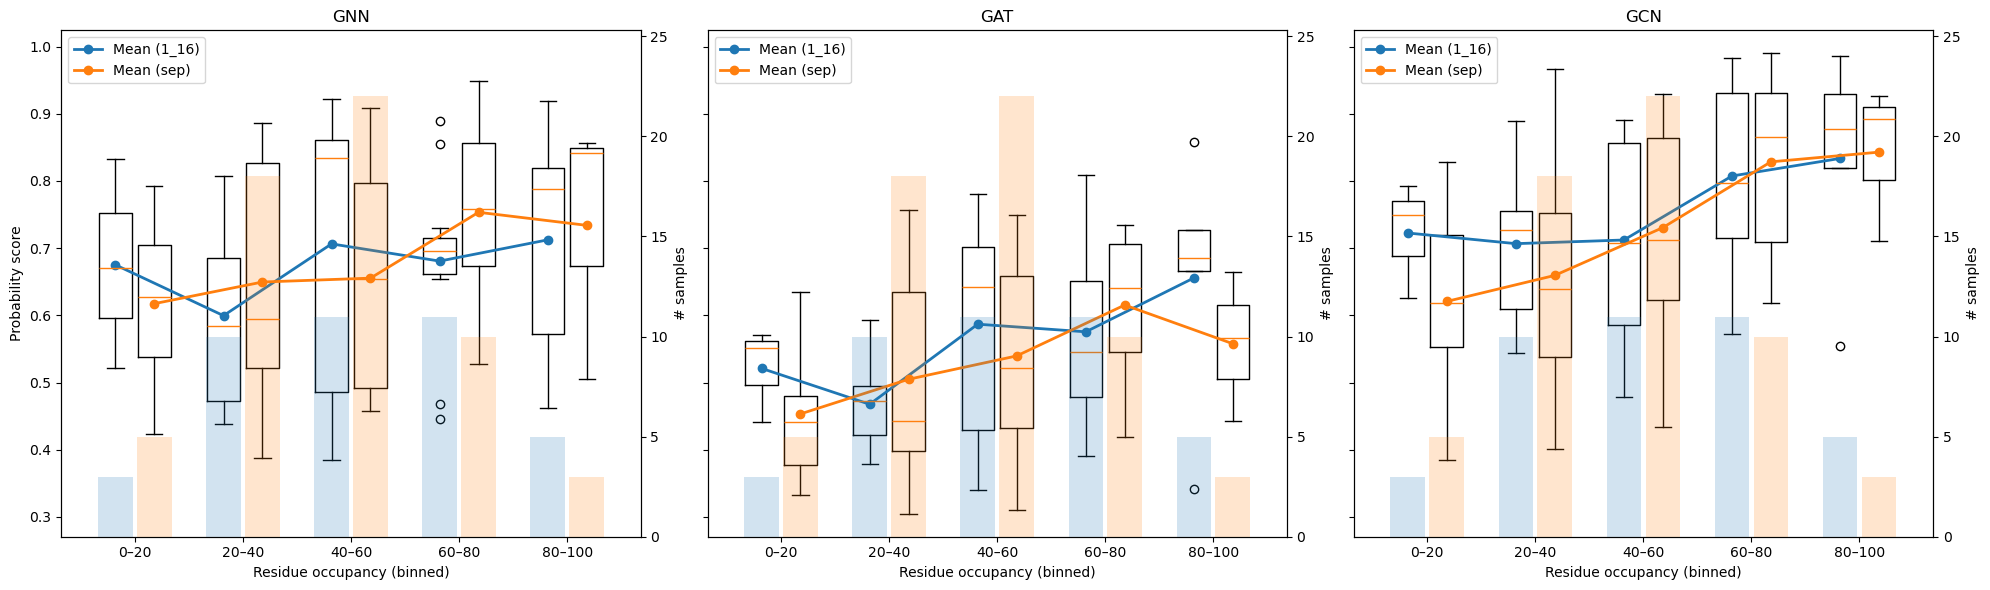

GNN: 1_16 rows=40, sep rows=58
GAT: 1_16 rows=40, sep rows=58
GCN: 1_16 rows=40, sep rows=58


In [1]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
BASE = Path(".")

# 1_16 results
MODEL_FILES_1_16 = {
    "GNN": BASE / "PU_EvalOutputs_Ensemble/1_16_results/CNN2D_graph_format_1_16/CNN2D_ENSEMBLE_eval_probs_and_labels.csv",
    "GAT": BASE / "PU_EvalOutputs_Ensemble/1_16_results/GAT_separate_graphs_1_16/GAT_ENSEMBLE_eval_probs_and_labels.csv",
    "GCN": BASE / "PU_EvalOutputs_Ensemble/1_16_results/GCN_separate_graphs_1_16/GCN_ENSEMBLE_eval_probs_and_labels.csv",
}
OCC_PREFIX_1_16 = "1_16-piezo-graph-5A"

# sep results
MODEL_FILES_SEP = {
    "GNN": BASE / "PU_EvalOutputs_Ensemble/CNN2D_graph_format_sep/CNN2D_ENSEMBLE_eval_probs_and_labels.csv",
    "GAT": BASE / "PU_EvalOutputs_Ensemble/GAT_separate_graphs_sep/GAT_ENSEMBLE_eval_probs_and_labels.csv",
    "GCN": BASE / "PU_EvalOutputs_Ensemble/GCN_separate_graphs_sep/GCN_ENSEMBLE_eval_probs_and_labels.csv",
}
OCC_PREFIX_SEP = "separate-piezo-graph-5A"

OCC_FILE = BASE / "average_delet_two_vaue_3dcnn_data.csv"

# Fixed bins requested
BIN_EDGES = np.array([0, 20, 40, 60, 80, 100], dtype=float)
BIN_LABELS = ["0–20", "20–40", "40–60", "60–80", "80–100"]

# =========================
# Helpers
# =========================
def extract_id_from_eval_filecol(s: str) -> str | None:
    # "2828_graphs.npy" -> "2828"
    m = re.match(r"(\d{4})", str(s))
    return m.group(1) if m else None

def extract_id_from_occ_filename(s: str) -> str | None:
    # ".../CHL1_2828-filtered_combined_matrix.npy" -> "2828"
    m = re.search(r"CHL1_(\d{4})", str(s))
    return m.group(1) if m else None

def load_model_eval_csv(path: Path, dataset_label: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["id4"] = df["file"].apply(extract_id_from_eval_filecol)
    df = df.dropna(subset=["id4"]).copy()
    df["prob"] = pd.to_numeric(df["prob"], errors="coerce")
    df = df.dropna(subset=["prob"]).copy()
    df["dataset"] = dataset_label
    return df

def load_occupancy_csv(path: Path, prefixes: list[str]) -> pd.DataFrame:
    occ = pd.read_csv(path)

    # keep only wanted prefixes
    fn = occ["filename"].astype(str)
    mask = False
    for p in prefixes:
        mask = mask | fn.str.startswith(p)
    occ = occ[mask].copy()

    occ["id4"] = occ["filename"].apply(extract_id_from_occ_filename)
    occ = occ.dropna(subset=["id4"]).copy()

    occ["high_occupancy"] = pd.to_numeric(occ["high_occupancy"], errors="coerce")
    occ = occ.dropna(subset=["high_occupancy"]).copy()

    # label which prefix it came from (useful for debugging)
    def which_prefix(x: str) -> str:
        for p in prefixes:
            if str(x).startswith(p):
                return p
        return "unknown"
    occ["occ_dataset"] = occ["filename"].astype(str).apply(which_prefix)

    # If duplicates per id4 exist, keep first (change to mean/max if desired)
    occ = occ.sort_values(["id4", "occ_dataset"]).drop_duplicates("id4", keep="first")
    return occ[["id4", "high_occupancy", "occ_dataset"]]

def assign_bins(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # clip to [0,100] just in case
    df["high_occupancy"] = df["high_occupancy"].clip(lower=0, upper=100)

    # left-closed, right-open bins => [0,20),..., [80,100)
    df["occ_bin"] = pd.cut(
        df["high_occupancy"],
        bins=BIN_EDGES,
        include_lowest=True,
        right=False,
        labels=BIN_LABELS
    )
    # put exactly 100 into last bin
    df.loc[df["high_occupancy"] == 100, "occ_bin"] = "80–100"

    df = df.dropna(subset=["occ_bin"]).copy()
    df["occ_bin"] = df["occ_bin"].astype(pd.CategoricalDtype(categories=BIN_LABELS, ordered=True))
    return df

# =========================
# Load occupancy (both prefixes)
# =========================
occ = load_occupancy_csv(OCC_FILE, prefixes=[OCC_PREFIX_1_16, OCC_PREFIX_SEP])

# =========================
# Load + merge results for both datasets
# =========================
def build_model_dfs(model_files: dict, dataset_label: str) -> dict[str, pd.DataFrame]:
    out = {}
    for model_name, csv_path in model_files.items():
        mdf = load_model_eval_csv(csv_path, dataset_label=dataset_label)
        mdf = mdf.merge(occ, on="id4", how="inner")   # only keep IDs that have occupancy info
        mdf = assign_bins(mdf)
        out[model_name] = mdf
    return out

dfs_1_16 = build_model_dfs(MODEL_FILES_1_16, dataset_label="1_16")
dfs_sep  = build_model_dfs(MODEL_FILES_SEP,  dataset_label="sep")

# =========================
# Plot: for each model, show BOTH datasets together in the same panel
# - Two boxplots per bin (offset): 1_16 vs sep
# - Mean overlay per dataset
# - Count bars per dataset (stacked-ish via offset; still on right axis)
# =========================
models_in_order = ["GNN", "GAT", "GCN"]

fig, axes = plt.subplots(1, len(models_in_order), figsize=(20, 6), sharey=True)
if len(models_in_order) == 1:
    axes = [axes]

x = np.arange(len(BIN_LABELS))
offset = 0.18
pos_1_16 = x - offset
pos_sep  = x + offset

for ax, model_name in zip(axes, models_in_order):
    dfA = dfs_1_16[model_name]
    dfB = dfs_sep[model_name]

    # Gather arrays per bin
    dataA = [dfA.loc[dfA["occ_bin"] == b, "prob"].values for b in BIN_LABELS]
    dataB = [dfB.loc[dfB["occ_bin"] == b, "prob"].values for b in BIN_LABELS]

    countsA = [len(arr) for arr in dataA]
    countsB = [len(arr) for arr in dataB]

    meansA = [np.mean(arr) if len(arr) else np.nan for arr in dataA]
    meansB = [np.mean(arr) if len(arr) else np.nan for arr in dataB]

    # Boxplots (same axis, offset positions)
    ax.boxplot(dataA, positions=pos_1_16, widths=0.30, patch_artist=False, showfliers=True)
    ax.boxplot(dataB, positions=pos_sep,  widths=0.30, patch_artist=False, showfliers=True)

    # Mean overlays
    ax.plot(pos_1_16, meansA, marker="o", linestyle="-", linewidth=2, label="Mean (1_16)")
    ax.plot(pos_sep,  meansB, marker="o", linestyle="-", linewidth=2, label="Mean (sep)")

    ax.set_title(model_name)
    ax.set_xlabel("Residue occupancy (binned)")
    ax.set_xticks(x)
    ax.set_xticklabels(BIN_LABELS)
    if ax is axes[0]:
        ax.set_ylabel("Probability score")

    # Secondary axis: bars for counts (offset to match their boxplots)
    ax2 = ax.twinx()
    ax2.bar(pos_1_16, countsA, alpha=0.20, width=0.32, label="# samples (1_16)")
    ax2.bar(pos_sep,  countsB, alpha=0.20, width=0.32, label="# samples (sep)")
    ax2.set_ylabel("# samples")
    ax2.set_ylim(0, max([1] + countsA + countsB) * 1.15)

    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

# =========================
# Quick sanity prints
# =========================
for model_name in models_in_order:
    print(f"{model_name}: 1_16 rows={len(dfs_1_16[model_name])}, sep rows={len(dfs_sep[model_name])}")
